In [144]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract
import random

In [145]:
df = pd.read_parquet("dataset/dev_withcrt.parquet")

In [146]:
df['cert_days'] = df['cert_validity_days'].apply(lambda x: int(x.split(" ")[0]))

In [147]:
names = pd.read_parquet("../analysis2/sni_used_to_generate_pcaps.parquet")

In [148]:
df = pd.merge(df, names, how='left', left_on='server_name_indication', right_on='sni')

In [149]:
df.shape

(371079, 124)

In [150]:
df.loc[df['device_id'].isna()].shape

(0, 124)

In [151]:
df.groupby(['serial_num', 'sni', 'issuer_CN', 'device_vendor'])['cert_id'].agg('count').reset_index(name='count').shape

(4949, 5)

### Leaf certificate validity days

In [152]:
_col2drop = ['cert_keyIdentifier', 'cert_sortedtime', 'cert_subjectKeyIdentifier', 'cert_mapped_idx', \
             'cert_cap_ts', 'cert_cap_uts', 'dev_dst_ip_x', 'dev_dst_port_x', 'dev_dst_sni', 'cert_idx_list', \
             'client_ciphersuite_code', 'client_compression_method', 'client_extension_type_code', 'client_hello_id', \
             'client_idx', 'client_sig_hash_alg_code', 'client_sig_hash_hash_code', 'client_supported_group_code', \
             'clnt_mapped_idx', 'clnt_cap_ts', 'clnt_cap_uts', 'clnt_ip_dst', 'clnt_ip_src', 'clnt_tcp_dstport', \
             'clnt_tcp_srcport', 'clnt_ts_idx_end', 'clnt_ts_idx_start', 'client_tls_version', 'client_ciphersuite', \
             'client_extension_type', 'client_supported_groups', 'client_sig_hash_alg', 'client_sig_hash_hash', \
             'if_weak_cipher_included', 'weak_cipher_included', 'weak_sigalg_included', 'dev_dst_ip_y', 'dev_dst_port_y', \
             'cert_ts_idx_end', 'cert_ts_idx_start', 'server_hello_id', 'server_idx', 'serv_mapped_idx', 'serv_cap_ts', \
             'serv_cap_uts', 'serv_ip_dst', 'serv_ip_src', 'serv_tcp_dstport', 'serv_tcp_srcport', 'serv_ts_idx_end', \
             'serv_ts_idx_start', 'dev_dst_ip', 'dev_dst_port']

In [153]:
dev_dropcol = df.drop([*_col2drop], 1)

In [154]:
dev_dropcol.sample(1)

,cert_alg_element,cert_basicConstraints_cA,cert_id,cert_idx,cert_ifCRLSign,cert_ifDataEncipherment,cert_ifDigitalSig,cert_ifKeyCertSign,cert_ifKeyEncipherment,cert_issuer,cert_public_key_exponent,cert_resourceIdentifier,cert_san,cert_sct_logid,cert_serialNum_from_ber,cert_serialNum_from_x509af,cert_sig_hash_hash,cert_sig_hash_sig,cert_sig_len,cert_subject,cert_version,serv_curve,cert_notBefore,cert_notAfter,cert_validity_days,cert_ip_dst,cert_ip_src,cert_tcp_dstport,cert_tcp_srcport,issuer_CN,issuer_O,issuer_OUnit,issuer_C,subject_CN,subject_O,subject_OUnit,subject_C,cert_sig_alg,if_weak_sig_alg,cert_loc,cert_chain_len,chain_issuer,chain_issuer_O,chain_issuer_CN,chain_subject,chain_subject_O,chain_subject_CN,chain_basicConstraintsCA,chain_ifKeyCertSign,chain_keyIdentifier,chain_subjectIdentifier,chain_serial_from_ber,chain_serial_from_x509af,server_name_indication,if_tls_fallback,if_weak_sigalg,server_ciphersuite,server_ciphersuite_code,server_compression_method,server_extension_type_code,server_tls_version,server_extension_type,if_weak_cipher,serial_num,response,cert_days,device_id,sni,device_vendor,device_name,user_key
21903,rsaEncryption,NaN,1.0,127.0,NaN,NaN,NaN,NaN,NaN,"rdnSequence: 3 items (id-at-commonName=Roku Server CA G2,id-at-organizationName=Roku, Inc.,id-at-countryName=US)",65537.0,None,"configsvc.cs.roku.com,",None,NaN,107d,None,None,NaN,"rdnSequence: 5 items (id-at-commonName=configsvc.cs.roku.com,id-at-organizationName=Roku Inc.,id-at-localityName=Los Gatos,id-at-stateOrProvinceName=California,id-at-countryName=US)",v3,None,2021-02-19 21:35:03,2023-03-21 21:35:03,760 days,67.205.150.252,54.85.54.49,50499,443,Roku Server CA G2,Roku,NaN,US,configsvc.cs.roku.com,Roku Inc.,NaN,US,sha256WithRSAEncryption,None,0,3,"[rdnSequence: 3 items (id-at-commonName=Roku Server CA G2,id-at-organizationName=Roku, Inc.,id-at-countryName=US), rdnSequence: 3 items (id-at-commonName=Roku Root CA G2,id-at-organizationName=Rok...","[Roku, Roku, Roku]","[Roku Server CA G2, Roku Root CA G2, Roku Root CA G2]","[rdnSequence: 5 items (id-at-commonName=configsvc.cs.roku.com,id-at-organizationName=Roku Inc.,id-at-localityName=Los Gatos,id-at-stateOrProvinceName=California,id-at-countryName=US), rdnSequence:...","[Roku Inc., Roku, Roku]","[configsvc.cs.roku.com, Roku Server CA G2, Roku Root CA G2]","[nan, 1.0, 1.0]","[None, None, None]","[fa343c74c017168dfe40320f34d04ac9393c4105, 61a8cc62c0cdc9b57c4ff87a64c7b2fa2c767660, 61a8cc62c0cdc9b57c4ff87a64c7b2fa2c767660]","[a4780a013e1ddfede69efd343f101b0626bf7c77, fa343c74c017168dfe40320f34d04ac9393c4105, 61a8cc62c0cdc9b57c4ff87a64c7b2fa2c767660]","[None, None, None]","[107d, 1000, 00dbc3088f01510c0b]",configsvc.cs.roku.com,False,False,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,c030,['0'],"['0', '65281', '11']",TLS 1.2,"['server_name', 'renegotiation_info', 'ec_point_formats']",False,107d,False,760,s3b5e72e94b,configsvc.cs.roku.com,tcl,roku,btgLK4a3MMdhg5c6


In [155]:
dev_dropcol['device_vendor'] = dev_dropcol['device_vendor'].fillna("missing")

In [156]:
# modified: previously no 'device_id'
df_leafval = dev_dropcol.loc[dev_dropcol['device_vendor'] != 'missing']\
                            [['device_vendor', 'sni', 'serial_num', 'response', \
                              'cert_days', 'issuer_O', 'issuer_CN', 'device_id', 'chain_issuer_O', 'chain_issuer_CN']]

In [157]:
df_leafval_drop = df_leafval.drop_duplicates(['device_vendor', 'sni', 'serial_num', 'issuer_O', 'issuer_CN', 'device_id', 'response', 'cert_days'])

In [158]:
df_leafval_drop.shape

(24480, 10)

In [159]:
df_leafval_temp = df_leafval_drop.groupby(['device_vendor'])['sni'].agg('count').reset_index(name='count')

In [160]:
df_leafval_merge = df_leafval_drop.merge(df_leafval_temp, how='inner', on='device_vendor')

In [161]:
df_leafval_sort = df_leafval_merge.sort_values(by='count', ascending=False)

In [162]:
df_leafval_sort['certday_log10'] = df_leafval_sort['cert_days'].apply(lambda x: np.log10(x))

In [163]:
df_leafval_sort.shape

(24480, 12)

#### Common & dev-spec issuer

In [164]:
public_lis = ['DigiCert', 'Amazon', 'Google Trust Services', 'Microsoft Corporation', 'Sectigo', 'GlobalSign nv-sa', \
              'GoDaddy.com', "Let's Encrypt", "Network Solutions", "Entrust", "Apple", "COMODO CA", \
              "COMODO Japan", "ZeroSSL", "Gandi", "TAIWAN-CA", "cPanel", "GlobalSign", "Starfield Technologies", \
              "The USERTRUST Network", "AddTrust AB", "Comodo CA Limited", "COMODO CA Limited", "The Go Daddy Group", \
              "Comodo Japan", "Sectigo Limited", "Apple Inc.", "DigiCert Inc", "Baltimore", "VeriSign", "Network Solutions L.L.C.", \
              "Symantec Corporation", "Google Trust Services LLC", "Trustwave Holdings", "Entrust.net", "Internet Security Research Group", \
              "Digital Signature Trust Co.", "SecureTrust Corporation"]

In [165]:
def chain_analysis(issuer_O_lis):
    ret = []
    for issuer_O in issuer_O_lis:       
        if issuer_O in public_lis:
            ret.append("public")
        else:
            ret.append("private")
    return '+'.join([str(v) for v in ret])

In [166]:
df_leafval_sort['issuer_O'] = df_leafval_sort['issuer_O'].fillna("missing")

In [167]:
def parse_issuer(text):
    if text.startswith('mediasoup'):
        return "mediasoup"
    return text.replace('\\', '').replace('\"', '')\
               .split(" Inc")[0].split(" INC")[0].split(" L.L.C.")[0].split(" LLC")[0].split(" llc")[0].split(" Hue")[0]\
               .split(" Co.")[0].split(" CO.")[0].split(" Ltd")[0].split(" Limited")[0].split(" GmbH")[0].split(" inc")[0].split(" CA")[0]

In [168]:
df_leafval_sort['issuer_O'] = df_leafval_sort['issuer_O'].apply(lambda x: parse_issuer(x))

In [169]:
df_leafval_sort.sample(1)

,device_vendor,sni,serial_num,response,cert_days,issuer_O,issuer_CN,device_id,chain_issuer_O,chain_issuer_CN,count,certday_log10
16522,amazon,secure.netflix.com,0efe36876de5c9be6700dd194a011588,False,31,Netflix,Netflix Public SHA2 RSA CA 3,s32b8bebcb1,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]",7485,1.491362


In [170]:
#df_leafval_sort['chain_issuer_O'] = df_leafval_sort['chain_issuer_O'].apply(lambda x: eval(x))

In [171]:
df_leafval_sort['chain_issuer'] = df_leafval_sort['chain_issuer_O'].apply(lambda x: chain_analysis(x))

In [172]:
df_leafval_sort['chain_issuer'].value_counts()

public+public+public               8595
public+public                      7795
public+public+public+public        4469
private+public                     2247
private+private                     666
private                             460
private+private+private             220
private+private+private+private      28
Name: chain_issuer, dtype: int64

In [173]:
df_leafval_sort.loc[df_leafval_sort['chain_issuer'] == "public+private+private"]['chain_issuer_O']

Series([], Name: chain_issuer_O, dtype: object)

In [174]:
def cate_chain(chain_issuer):
    if chain_issuer == "public+public+public" or \
     chain_issuer == "public+public" or \
     chain_issuer == "public+public+public+public":
        return "Public trust leaf and root certificates"
    
    elif chain_issuer == "private+public":
        return "Private leaf, public trust root certificates"
    
    else:
        return "Private leaf and root certificates"

In [175]:
df_leafval_sort['chain_category'] = df_leafval_sort['chain_issuer'].apply(lambda x: cate_chain(x))

In [176]:
df_leafval_sort['chain_category'].value_counts()

Public trust leaf and root certificates         20859
Private leaf, public trust root certificates     2247
Private leaf and root certificates               1374
Name: chain_category, dtype: int64

In [177]:
def jitter(x):
    return x + random.uniform(0, .5) - .25

In [178]:
df_leafval_sort['device_vendor'] = df_leafval_sort['device_vendor'].apply(lambda x: x.capitalize())

In [179]:
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Lg')] = 'LG'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Directv')] = 'DirecTV'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Dish network')] = 'Dish Network'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Tcl')] = 'TCL'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Tplink')] = 'TP-Link'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Western digital')] = 'Western Digital'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Hp')] = 'HP'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ihome')] = 'iHome'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ikea')] = 'IKEA'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Irobot')] = 'iRobot'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Qnap')] = 'QNAP'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Echobee')] = 'echobee'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Idevices')] = 'iDevices'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Vmware')] = 'VMware'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ecobee')] = 'ecobee'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ubiquity')] = 'Ubiquiti'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Silicondust')] = 'SiliconDust'

<ipython-input-179-b6a8cc46603f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-179-b6a8cc46603f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-179-b6a8cc46603f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_

In [180]:
df_leafval_sort['device_vendor'].value_counts()

Amazon               7485
Google               4837
Roku                 3196
Samsung              1876
Sony                 1384
LG                    825
Nvidia                633
TCL                   494
Tivo                  405
Sonos                 366
Synology              338
HP                    296
Xiaomi                241
Cisco                 232
Insignia              209
Nintendo              201
Vizio                 159
Logitech              130
Wyze                  104
Sharp                 103
Wink                  101
QNAP                   99
Brother                69
TP-Link                59
Lutron                 57
Philips                52
Tesla                  52
Netatmo                34
Dish Network           33
Amcrest                32
Denon                  32
Panasonic              30
NETGEAR                28
Pioneer                25
ecobee                 21
Sense                  21
Onkyo                  20
IKEA                   18
Canary      

In [181]:
df_leafval_sort = df_leafval_sort.loc[df_leafval_sort['device_vendor'] != "Unknown"]

In [182]:
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "Roku", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "Nintendo of America", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "Sony Computer Entertainment", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "Samsung Electronics", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "Sense Labs", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "LG Electronics", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "Philips", "response"] = False
#df_leafval_sort.loc[df_leafval_sort.issuer_O == "ecobee", "response"] = False

In [183]:
vendor_ids = {'Amazon': 1, 'Samsung':2, 'Roku': 3, 'Google': 4, 'LG':5, \
            'Sony': 6, 'Nvidia': 7, 'Cisco': 8, 'Tivo': 9, 'Xiaomi': 10, \
            'HP': 11, 'Insignia': 12, 'TCL': 13, 'Wink': 14, 'Vizio': 15, \
            'Sharp': 16, 'Brother': 17, 'Synology': 18, 'Lutron': 19, 'Sonos': 20, \
            'Nintendo': 21, 'Amcrest': 22, 'TP-Link': 23, 'Panasonic': 24, 'Tesla': 25, \
            'Logitech': 26, 'Philips': 27, 'Netatmo': 28, 'Dish Network': 29, \
            'Sky': 30, 'QNAP': 31, 'Pioneer': 32, 'Onkyo': 33, \
            'iDevices': 34, 'NETGEAR': 35, 'Humax': 36, 'iRobot': 37, \
            'Wyze': 38, 'DirecTV': 39, 'Sense':40, \
             'Ubiquiti':41, 'ecobee':42, 'Texas Instruments':43, 'Arlo':44, \
             'Denon':45, 'VMware':46, 'Canon':47, 'Epson':48,\
             'IKEA':49, 'Western Digital':50, 'Belkin':51, 'Bose':52, \
             'SiliconDust':53, 'Withings': 54, 'HDHomeRun':55, 'Marantz':56, 'Canary':57, \
             'Vera':58, 'Yamaha':59, 'Tuya':60, 'Fing':61, 'Nanoleaf':62, \
             'Sleep Number':63, 'Obihai':64, 'Skybell':65}

df_leafval_sort['vendor_id'] = df_leafval_sort['device_vendor'].apply(lambda x: vendor_ids[x])
df_leafval_sort['jittered'] = df_leafval_sort['vendor_id'].apply(lambda x: jitter(x))

In [184]:
df_leafval_sort = df_leafval_sort.rename(columns={'response': 'In CT', 'chain_category': 'Chain status'})

In [185]:
df_leafval_sort['Chain status'].value_counts().nlargest()

Public trust leaf and root certificates         20856
Private leaf, public trust root certificates     2247
Private leaf and root certificates               1374
Name: Chain status, dtype: int64

In [188]:
df_leafval_sort.loc[df_leafval_sort['Chain status'] == "Private leaf, public trust root certificates"]['device_vendor'].value_counts()

Roku            586
Amazon          550
Sony            201
Samsung         186
LG              153
Nvidia          124
TCL             104
Tivo             87
Xiaomi           27
Dish Network     27
Sharp            27
Insignia         26
Google           17
Panasonic        17
Brother          15
Vizio            14
Wink             14
HP               13
Amcrest          13
Sky              12
SiliconDust       7
Synology          7
QNAP              6
Cisco             5
Philips           4
iRobot            1
Humax             1
HDHomeRun         1
NETGEAR           1
Lutron            1
Name: device_vendor, dtype: int64

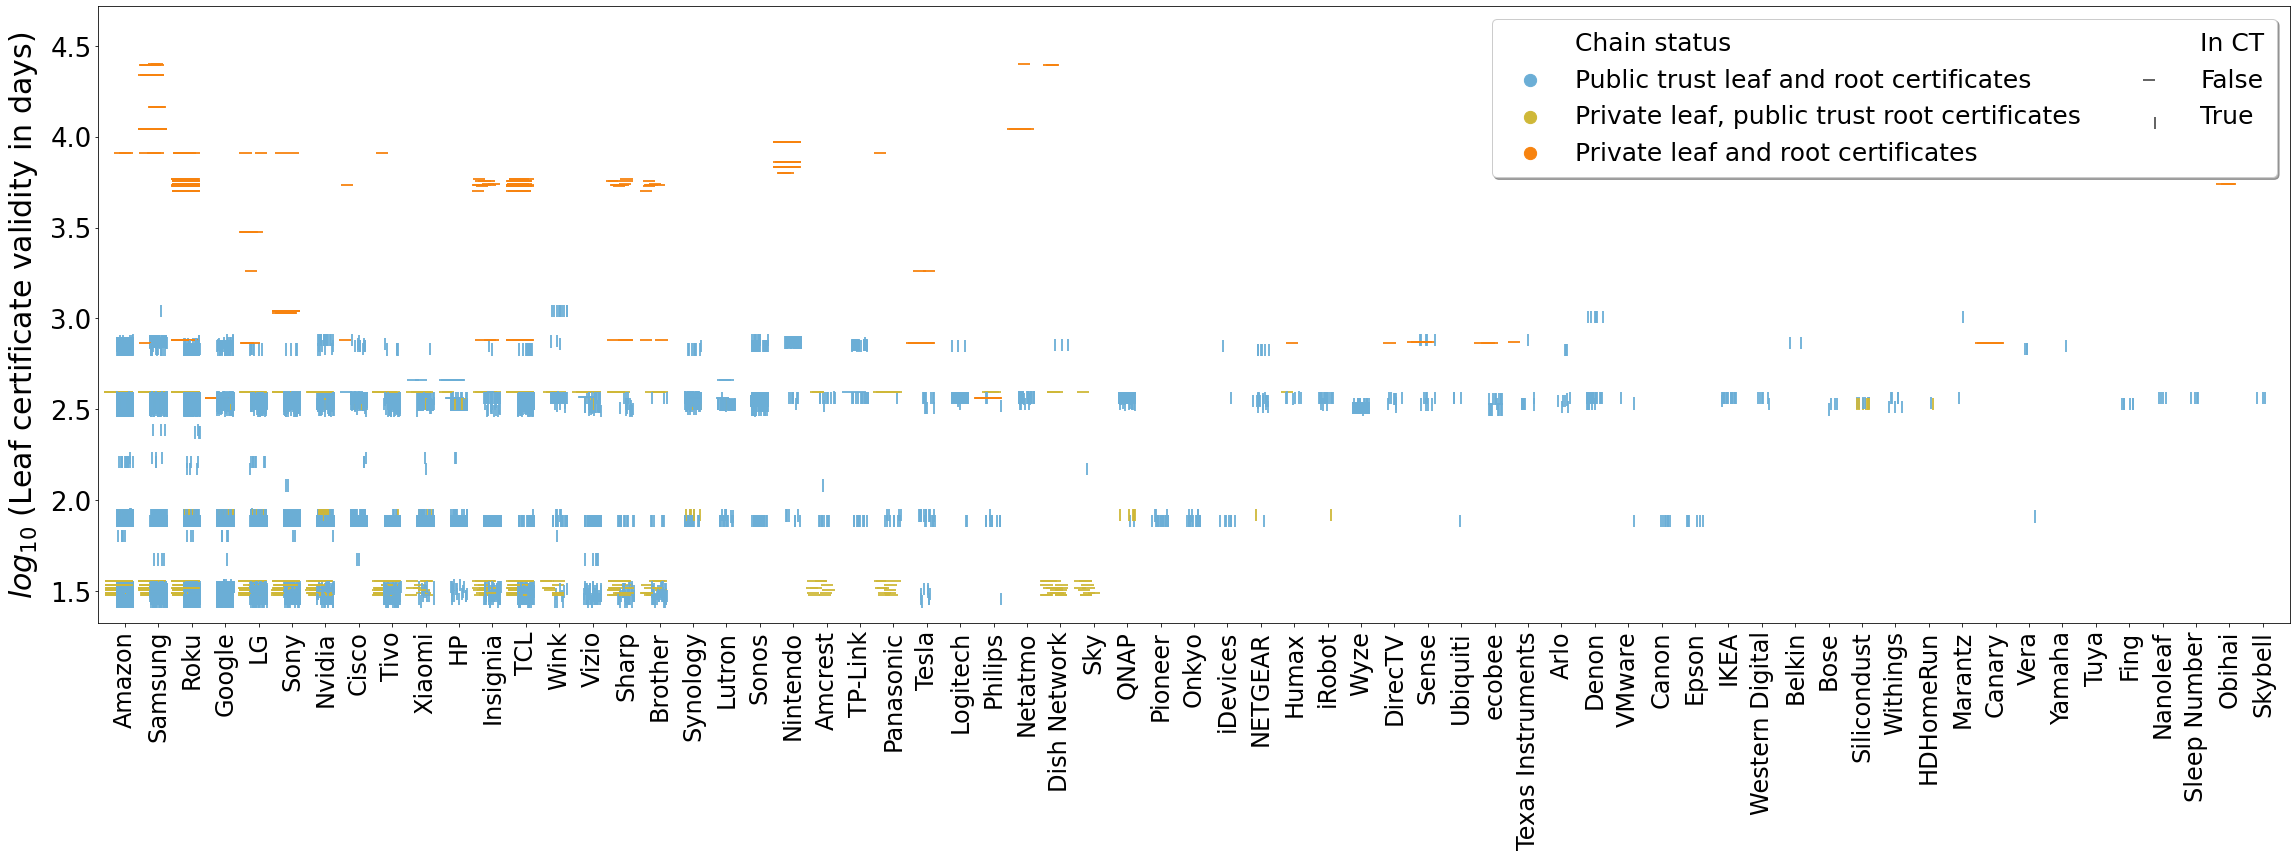

In [186]:
fig = plt.figure(figsize=(32,12))
#sns.despine(bottom=True, left=True)

#issuer_palette = ["#E6550D", "#9ECAE1"]
issuer_palette = ["#6baed6", "#cfb838", '#f7830f']
markers = {False: 0, True: 3}

ax = sns.scatterplot(x="jittered", y="certday_log10", hue="Chain status", style="In CT", s=150, \
                   palette=issuer_palette, markers=markers, \
                   data=df_leafval_sort, alpha=.9, linewidth=2, x_jitter=True)

ax.set_xlim(0.2, 65.8)
ax.set_xlabel('')
ax.set_ylabel("$log_{10}$ (Leaf certificate validity in days)", fontsize=30, labelpad=10)

plt.yticks(fontsize=26)

#ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')

handles, labels = ax.get_legend_handles_labels()
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90, ha='right', va='center',rotation_mode='anchor')
legend = ax.legend(handles=handles[0:], labels=labels[0:], title="", \
                   loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2,\
                   fontsize=25)
legend.get_frame().set_alpha(None)
for handle in legend.legendHandles:
    handle.set_sizes([150.0])

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,\
            26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,\
           48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65], rotation=90, fontsize=22)
ax.set_xticklabels(['Amazon', 'Samsung', 'Roku', 'Google', 'LG', \
                    'Sony', 'Nvidia', 'Cisco', 'Tivo', 'Xiaomi', \
                    'HP', 'Insignia', 'TCL', 'Wink', 'Vizio', \
                    'Sharp', 'Brother', 'Synology', 'Lutron', 'Sonos', \
                    'Nintendo', 'Amcrest', 'TP-Link', 'Panasonic', 'Tesla', \
                    'Logitech', 'Philips', 'Netatmo', 'Dish Network', \
                    'Sky', 'QNAP', 'Pioneer', 'Onkyo', \
                    'iDevices', 'NETGEAR', 'Humax', 'iRobot', \
                    'Wyze', 'DirecTV', 'Sense', \
                    'Ubiquiti', 'ecobee', 'Texas Instruments', 'Arlo', \
                    'Denon', 'VMware', 'Canon', 'Epson',\
                    'IKEA', 'Western Digital', 'Belkin', 'Bose', \
                    'Silicondust', 'Withings', 'HDHomeRun', 'Marantz', 'Canary', \
                    'Vera', 'Yamaha', 'Tuya', 'Fing', 'Nanoleaf', \
                    'Sleep Number', 'Obihai', 'Skybell'], \
                    fontsize=24, rotation=90, ha='right', va='center',rotation_mode='anchor')


fig.tight_layout()
fig.savefig("figures/vendor_issuer_crtsh_ver2.png", dpi=150)
plt.show()

### Extremely long certificates

In [81]:
df_leafval_sort.sample(1)

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered
1826,Google,frontdoor.nest.com,47d243f1b32d248a,False,365,Nest Labs,Nest Private Server Certificate Authority,scfcc1b1d80,4837,2.562293,Untrust,4,3.941927


In [80]:
df_leafval_sort.loc[df_leafval_sort['Issuer'] == 'Untrust'].drop_duplicates(['serial_num', 'issuer_CN']).shape

(76, 13)

In [82]:
df_leafval_sort.loc[(df_leafval_sort['Issuer'] == 'Untrust') & \
                    (df_leafval_sort['cert_days'] > 1826)].drop_duplicates(['serial_num', 'issuer_CN']).shape

(35, 13)

In [51]:
df_leafval_drop.loc[df_leafval_drop['cert_days'] > 1000].groupby("issuer_O")['cert_days'].agg('max').reset_index(name='max').sort_values(by='max', ascending=False)

,issuer_O,max
14,nan,36500
10,Samsung Electronics,25202
1,EchoStar,24855
13,Universal Electronics Inc,21946
9,Samsung,10950
6,Nintendo of America Inc.,9300
4,Netflix Inc,8150
5,Nintendo of America,7233
8,Roku,5854
7,Obihai Technology Inc.,5475


In [52]:
df_leafval_drop.loc[(df_leafval_drop['issuer_O'] == 'nan') & \
                    (df_leafval_drop['cert_days'] == 36500)]

,device_vendor,sni,serial_num,response,cert_days,issuer_O,issuer_CN,device_id
21428,tuya,a2.tuyaus.com,0086cd856e1ee3ae33,False,36500,nan,nan,s5404e0848a
21429,tuya,a2.tuyaus.com,0086cd856e1ee3ae33,False,36500,nan,nan,s7cb977087f
21430,tuya,a2.tuyaus.com,0086cd856e1ee3ae33,False,36500,nan,nan,sd895140d26


### Not in CT

In [169]:
serial = "E84177AB21D3317EADE71FDE938A41C8".lower()

In [171]:
serial

'e84177ab21d3317eade71fde938a41c8'

In [170]:
df_leafval.loc[df_leafval['serial_num'] == serial]['sni'].value_counts() 

Series([], Name: sni, dtype: int64)

In [53]:
pd.set_option('display.max_colwidth', None)

In [54]:
df_leafval.sample(1)

,device_vendor,sni,serial_num,response,cert_days,issuer_O,issuer_CN,device_id
315756,roku,giga.logs.roku.com,202a,False,5416,Roku,nan,s9c1cba6e59


In [55]:
df_notct = df_leafval.loc[df_leafval['response'] == False]

In [56]:
df_notct.shape

(40772, 8)

In [87]:
df_notct['issuer_O'] = df_notct['issuer_O'].apply(lambda x: parse_issuer(x))

<ipython-input-87-7ef7629fb151>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notct['issuer_O'] = df_notct['issuer_O'].apply(lambda x: parse_issuer(x))


In [88]:
tab1 = df_notct.groupby(['issuer_O'])['sni'].agg(sni_set=lambda x: set(x), sni_count=lambda x: len(set(x))).reset_index()

In [89]:
tab2 = df_notct.groupby(['issuer_O'])['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [90]:
tab3 = df_notct.groupby(['issuer_O'])['serial_num'].agg(cert_count=lambda x: len(set(x))).reset_index()

In [91]:
tab4 = df_notct.groupby(['issuer_O'])['device_id'].agg(dev_set=lambda x: set(x)).reset_index()

In [92]:
tab5 = df_notct.groupby(['issuer_O'])['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [93]:
tab_merge = pd.merge(tab1, tab2, how='inner', left_on=['issuer_O'], right_on=['issuer_O']).sort_values('sni_count', ascending=False)

In [94]:
tab_merge = pd.merge(tab3, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [95]:
tab_merge = pd.merge(tab4, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [96]:
tab_merge = pd.merge(tab5, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [97]:
tab_merge.sort_values('devnum', ascending=False)

,issuer_O,devnum,dev_set,cert_count,sni_set,sni_count,vendor_set
7,Netflix,280,"{s790e737e14, s4365827f31, s879a0b4a45, sf68f1809fc, s336f5de079, s95ccf22f96, s97da71e5cd, sa8832ada84, s83b59a8b29, s95d56d0457, s5124c9f37c, seead2b996f, sbade24f24f, sdb98aed595, sb82fe181b1, s0cfb9b11b6, se4859dd20f, s83ebaf5591, sba8d3874fc, s9580395170, s3f2ffcb5e9, s98b0054b80, sfcd21b3bce, saf83370dfd, s2c25f09247, s456fbd5382, sb5b67a8ddc, s02e268892f, s33fec7ad4d, s366108f010, sd0cd9d7aa5, s3b5e72e94b, s115938e8d8, s2ff0b39a69, sef1f46b3ef, sa4b89606bd, s2db497817c, s11d938429c, s2ffc21ca1e, s3edb13b126, sde1818f912, sa3a8407c69, s2a040f8db0, sa43bd7699b, s8d3d28bced, s34a561843b, s20c3244ee8, s8ee8334fff, s32a8d6f539, s7d18fc126b, s8fd7acf70d, s0dda052cba, s13f13f54f2, s2f423e2e4b, s4e5f48545a, s6f183f11b4, sb3a10fe636, s547863ce35, s3e3190c411, saabb2db8d8, s4156fd53bc, sbf4549f1e7, se78f68fb61, saf0c12496d, sffc152f21e, s43e796d99a, sc58f34c6c2, s0ab7d753f2, s4668581311, s6fd82a52e0, s73b06dce8b, s088a528f27, s580272406e, s6008f35598, s88b0a7cb4a, s3bf08b42b8, s538a738b0e, s72590d39b5, s6387772af1, s7f1d85e281, s826b925b18, s19277670e1, s4268f096cd, s31ffd188e6, s798ea3bedc, scbbef1e35d, seaa8d5316e, s3fe9b67697, sd5f52d32e1, s198fbc43f1, s52d431acac, sa9387a7ede, saaec044562, sc6733c84cd, saa5467b8e6, s64fd01d88e, s24c6c1c71a, sb0d9c4b5d0, s6d591581f3, sdf2756a86b, ...}",16,"{appboot.netflix.com, nrdp50-appboot.netflix.com, nrdp51-appboot.netflix.com, api.netflix.com, secure.netflix.com, uiboot.netflix.com, customerevents.netflix.com, nrdp.nccp.netflix.com, nccp-nrdp-31.cloud.netflix.net, api-global.netflix.com, ichnaea.netflix.com}",11,"[amazon, amcrest, brother, dish network, hp, humax, insignia, lg, nvidia, panasonic, philips, roku, samsung, sharp, sky, sony, tcl, tivo, vizio, wink, xiaomi]"
11,Roku,134,"{s879a0b4a45, s336f5de079, s83b59a8b29, sb82fe181b1, sbade24f24f, s83ebaf5591, seead2b996f, s0cfb9b11b6, s8d695bf07f, sba8d3874fc, s286a5f488d, sb5b67a8ddc, s02e268892f, s33fec7ad4d, sd0cd9d7aa5, s366108f010, s3b5e72e94b, sa4b89606bd, s2db497817c, s5b0b8e5ba8, s3edb13b126, sa3a8407c69, s2a040f8db0, sa43bd7699b, s20c3244ee8, s13f13f54f2, s8fd7acf70d, s6f183f11b4, s2bd397eabf, s9712773c82, s547863ce35, sffc152f21e, s619a795537, saf0c12496d, sc58f34c6c2, s0ab7d753f2, sbbcb5702e6, s73b06dce8b, s94869260ec, s6008f35598, s19277670e1, s1af13897ad, sbc570b5d21, scbbef1e35d, sd5f52d32e1, s24c6c1c71a, s5e83062a24, s6d591581f3, sdf2756a86b, sb8b1a56f9a, sd4cd5ca7c6, s57bca9d644, sb9191a5fc8, sf3556edde0, s43277f2d0a, se5b5933d85, s9bd88d6f5c, s17ceff62c1, s7465a6cc23, sf24a6bd8a3, sc3520ec27b, s6346c90dec, s334509ed34, s178169d84a, s8e57fbb18d, sdc933deb8e, sc2b7834444, s692a0a7478, sed3a95a185, sd434a5c032, sce5b924cef, s840467e83d, s7622fb49b5, s7a1f4713f2, sa4d5b33226, sdf200ffd38, s6c2a4f75d7, s922f20cc76, sf6255ed86e, s408587971b, s9d10933f3f, s9dbeeedbb9, sbafa0069e9, sfcb59bb1cc, s7b76dfe770, s404a230fbb, s8ebedefc72, s0b7722af83, s64ba23cdb3, s39bd6c2ef7, s0222d29760, sff73dd5bb7, s21e27cf918, s10f8b80bef, s587f419a9c, safc1350b4e, sf878656922, scd33cffebe, s2211f1d083, sae648cf49a, ...}",11,"{i.ads.roku.com, sugarland.sb.roku.com, scribe.logs.roku.com, liberty.logs.roku.com, austin.sb.roku.com, api2.sr.roku.com, bryan.sw.roku.com, gilbert.sw.roku.com, austin.logs.roku.com, giga.sb.roku.com, cooper.logs.roku.com, cooper.sb.roku.com, longview.sb.roku.com, liberty.sw.roku.com, api.roku.com, content.sr.roku.com, longview.sw.roku.com, giga.sw.roku.com, api.sr.roku.com, api.rokutime.com, austin.sw.roku.com, sugarland.sw.roku.com, liberty.sb.roku.com, gilbert.sb.roku.com, configsvc.cs.roku.com, bryan.sb.roku.com, giga.logs.roku.com, amarillo.sw.roku.com, tis.cti.roku.com, amarillo.sb.roku.com, cloudservices.roku.com}",31,"[brother, cisco, insignia, roku, sharp, tcl]"
6,Nest Labs,65,"{s7b77742bbd, s162f2f13a7, s3d72f0d7e5, sc0e98160e7, sebb24940a1, s2b6bfa2612, s7ad415490c, s1e7316017c, s0711690213, se27d76dfc2, s55e159e302, sb2ad999d97, sb

### In CT: untrust issuer

In [112]:
df_leafval_sort.sample(1)

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered
13723,Amazon,msh.amazon.com,06ee82236041d44874731b2edb23102c,True,357,Amazon,Amazon,s9c15cf81ab,7485,2.552668,Public trust,1,1.104023


In [106]:
df_ct = df_leafval_sort.loc[(df_leafval_sort['In CT'] == True) &\
                            (df_leafval_sort['Issuer'] == "Untrust")]

In [107]:
df_ct.shape

(0, 13)

In [108]:
df_ct2 = df_leafval_sort.loc[(df_leafval_sort['In CT'] == False) &\
                            (df_leafval_sort['Issuer'] == "Public trust")]

In [110]:
df_ct2.shape

(32, 13)

#### Previous

In [144]:
tab1 = df_ct.groupby(['issuer_O'])['server_name_indication'].agg(sni_set=lambda x: set(x), sni_count=lambda x: len(set(x))).reset_index()

In [145]:
tab2 = df_ct.groupby(['issuer_O'])['device_vendor'].agg(vendor_set=lambda x: set(x)).reset_index()

In [146]:
tab3 = df_ct.groupby(['issuer_O'])['cert_serialNum_from_x509af'].agg(cert_count=lambda x: len(set(x)))

In [147]:
tab4 = df_ct.groupby(['issuer_O'])['cert_serialNum_from_x509af'].agg(cert_set=lambda x: set(x))

In [148]:
tab_merge = pd.merge(tab1, tab2, how='inner', left_on=['issuer_O'], right_on=['issuer_O']).sort_values('sni_count', ascending=False)

In [149]:
tab_merge = pd.merge(tab3, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [150]:
tab_merge = pd.merge(tab4, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [151]:
tab_merge.sort_values('cert_count', ascending=False)

,issuer_O,cert_set,cert_count,sni_set,sni_count,vendor_set
0,Netflix,"{080de471c1ac6e66b2c3030064e161ea, 030f25774bcfdd0d6e146f848182a856, 0649fc23f0f52976113ef503612d6fda}",3,"{api.netflix.com, secure.netflix.com, api-global.netflix.com, uiboot.netflix.com}",4,"{Nvidia, Sharp, Xiaomi, Sky, Philips, HP, Amcrest, Brother, Roku, LG, Tivo, Amazon, Wink, Samsung, Vizio, Sony, Dish Network, TCL, Insignia, Panasonic}"


### Roku

In [158]:
df_leafval_sort.loc[df_leafval_sort['sni'].str.contains("roku")].groupby(['issuer_O', 'cert_days'])['sni'].agg('count').reset_index(name='count')

,issuer_O,cert_days,count
0,Amazon,393,214
1,Amazon,394,45
2,COMODO,365,36
3,DigiCert,381,24
4,Let's Encrypt,89,10
5,Roku,760,138
6,Roku,5005,38
7,Roku,5329,66
8,Roku,5416,197
9,Roku,5469,42


### Netflix

In [159]:
df_leafval_sort.loc[(df_leafval_sort['sni'].str.contains("netflix")) | (df_leafval_sort['sni'].str.contains("nflx"))].groupby('issuer_O')['sni'].agg('count')

issuer_O
DigiCert    4031
Netflix     2114
Name: sni, dtype: int64

In [160]:
df_leafval_sort.sample(1)

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered
8290,Sony,fling.cid.samba.tv,5283a6dd1642389d,True,397,GoDaddy.com,Go Daddy Secure Certificate Authority - G2,s4e406d9d6d,1384,2.598791,Public trust,6,6.003724


In [161]:
netflix = df_leafval_sort.loc[df_leafval_sort['issuer_O'].str.startswith("Netflix")]

In [162]:
netflix.shape

(2114, 13)

In [163]:
netflix1 = netflix.groupby(['In CT', 'issuer_CN'])['serial_num'].agg(cert_set=lambda x: set(x), num_cert=lambda x: len(set(x))).reset_index()

In [164]:
netflix2 = netflix.groupby(['In CT', 'issuer_CN'])['cert_days'].agg(cert_days=lambda x: set(x)).reset_index()

In [165]:
netflix3 = netflix.groupby(['In CT', 'issuer_CN'])['sni'].agg(sni_set = lambda x: set(x)).reset_index()

In [166]:
netflix_merge = pd.merge(netflix1, netflix2, left_on=['In CT', 'issuer_CN'], right_on=['In CT', 'issuer_CN'], how='inner')

In [167]:
netflix_merge = pd.merge(netflix_merge, netflix3, left_on=['In CT', 'issuer_CN'], right_on=['In CT', 'issuer_CN'], how='inner')

In [168]:
netflix_merge

,In CT,issuer_CN,cert_set,num_cert,cert_days,sni_set
0,False,Netflix Public SHA2 RSA CA 3,"{0c259feba33d6f31abb666e83ba20b31, 0efe36876de5c9be6700dd194a011588, 097c73332d504b2a359ec1d27c5e033b, 055831176ef62f55a2e0af91b558b8e5, 099f0ff9b649373551b6168218d31749, 0a3221a7ebf99d71960d31fe425ab69d, 0b205647250c3b6496039f582b124119, 0da990551346461563aee07f8691defe, 01169f1249562ecceb486641ec1a8f45, 05f305e73708715d5da07e9300952cd0, 0d583a8e2d5df32d424589ec81c5e851, 0ab3ec48f76a43d67558d10bbf08447c, 0cd420cc759ce8e96c3be53494dfc711}",13,"{32, 33, 34, 36, 396, 30, 31}","{secure.netflix.com, api.netflix.com, customerevents.netflix.com, uiboot.netflix.com, api-global.netflix.com, ichnaea.netflix.com}"
1,False,Primary Certificate Authority,"{01131c26d92130743a79219ad2292c8deed5, 019a641b97c22001a7994740b3f19a543696, 01505884ca4a937e9131068877e360301a4a}",3,{8150},"{appboot.netflix.com, nrdp50-appboot.netflix.com, nrdp51-appboot.netflix.com, nrdp.nccp.netflix.com, nccp-nrdp-31.cloud.netflix.net}"


In [132]:
netflix_serial = list(set(netflix['serial_num'].tolist()))

In [133]:
netflix_serial

['0c259feba33d6f31abb666e83ba20b31',
 '0efe36876de5c9be6700dd194a011588',
 '097c73332d504b2a359ec1d27c5e033b',
 '055831176ef62f55a2e0af91b558b8e5',
 '019a641b97c22001a7994740b3f19a543696',
 '0a3221a7ebf99d71960d31fe425ab69d',
 '099f0ff9b649373551b6168218d31749',
 '0b205647250c3b6496039f582b124119',
 '0da990551346461563aee07f8691defe',
 '01131c26d92130743a79219ad2292c8deed5',
 '01169f1249562ecceb486641ec1a8f45',
 '05f305e73708715d5da07e9300952cd0',
 '0d583a8e2d5df32d424589ec81c5e851',
 '01505884ca4a937e9131068877e360301a4a',
 '0ab3ec48f76a43d67558d10bbf08447c',
 '0cd420cc759ce8e96c3be53494dfc711']

In [122]:
iot_ssl = pd.read_csv("/Users/hongyingdong/Documents/iot-study/iot-ny0418/pcap_extracted/zeek_ssl.csv")

In [123]:
iot_ssl.sample(1)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status
10766,1650123587.617423,C8rVZ33Bh2eQF2kb86,67.205.150.252,40738.0,142.251.40.142,443.0,TLSv12,TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256,-,encrypted-tbn0.gstatic.com,F,-,-,T,CsxknGIti,"72be6d3c2b2a291f2cbf74a4020df57d9db774a472027852d1255ddf4611518c,23ecb03eec17338c4e33a6b48a41dc3cda12281bbc3ff813c0589d6cc2387522,3ee0278df71fa3c125c4cd487f01d774694e6fc57e0cd94c24efd769133918e5",(empty),T,ok


In [124]:
iot_ssl.shape

(45874, 19)

In [125]:
iot_x509 = pd.read_csv("/Users/hongyingdong/Documents/iot-study/iot-ny0418/pcap_extracted/zeek_x509.csv")

In [126]:
iot_x509.sample(1)

,ts,fingerprint,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert
30110,1650129638.698316,fa153341d4493a7ae93096b7c85a1b829ec5597b7b93591253ddffc5079461b0,3.0,0E37426371650FAD1D5F2E7D00159F07,"CN=*.wyzecam.com,O=WYZE LABS INC.,L=Kirkland,ST=Washington,C=US","CN=DigiCert TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US",1.638248e+09,1.669784e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"*.wyzecam.com,wyzecam.com",-,-,-,F,-,T,F


In [134]:
netflix_cert=[]
for serial in netflix_serial:
    serial = serial.upper()
    netflix_cert.append(serial)

In [135]:
netflix_cert

['0C259FEBA33D6F31ABB666E83BA20B31',
 '0EFE36876DE5C9BE6700DD194A011588',
 '097C73332D504B2A359EC1D27C5E033B',
 '055831176EF62F55A2E0AF91B558B8E5',
 '019A641B97C22001A7994740B3F19A543696',
 '0A3221A7EBF99D71960D31FE425AB69D',
 '099F0FF9B649373551B6168218D31749',
 '0B205647250C3B6496039F582B124119',
 '0DA990551346461563AEE07F8691DEFE',
 '01131C26D92130743A79219AD2292C8DEED5',
 '01169F1249562ECCEB486641EC1A8F45',
 '05F305E73708715D5DA07E9300952CD0',
 '0D583A8E2D5DF32D424589EC81C5E851',
 '01505884CA4A937E9131068877E360301A4A',
 '0AB3EC48F76A43D67558D10BBF08447C',
 '0CD420CC759CE8E96C3BE53494DFC711']

In [136]:
iot_ssl['cert_chain_fps'] = iot_ssl['cert_chain_fps'].fillna("missing")

In [137]:
iot_ssl['fingerprint'] = iot_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[0])

In [138]:
netflix_finger_lis = list(set(iot_x509.loc[iot_x509['certificate.serial'].isin(netflix_cert)]['fingerprint'].tolist()))

In [139]:
netflix_ssl = iot_ssl.loc[iot_ssl['fingerprint'].isin(netflix_finger_lis)]

In [140]:
netflix_ssl.shape

(220, 20)

In [141]:
netflix_ssl['cert_chain_len'] = netflix_ssl['cert_chain_fps'].apply(lambda x: len(x.split(",")))

<ipython-input-141-a9ed37d8f59b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_ssl['cert_chain_len'] = netflix_ssl['cert_chain_fps'].apply(lambda x: len(x.split(",")))


In [142]:
netflix_ssl['cert_chain_len'].value_counts().nlargest(10)

2    220
Name: cert_chain_len, dtype: int64

In [143]:
netflix_ssl.sample(3)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,cert_chain_len
11762,1650129449.709408,CDkC9e4igNiJwWT8t3,67.205.150.252,41886.0,45.57.91.1,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,x25519,secure.netflix.com,F,-,-,T,CsxknGIti,"e7be7ea2287c469520af2b64db7e48f067a667de641410bbb1c967eaf33e6b66,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,e7be7ea2287c469520af2b64db7e48f067a667de641410bbb1c967eaf33e6b66,2
43700,1650126102.056942,CYXdI14rfKNlYueO3l,67.205.150.252,52511.0,52.49.69.103,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,uiboot.netflix.com,F,-,-,T,CsxknGIi,"2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,2
360,1650130840.613970,CpjWkM29TjhRQvqxo8,67.205.150.252,63169.0,52.1.25.196,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,nrdp.nccp.netflix.com,F,-,-,T,CsxknGIi,"8f96e9f52e3ca489761ba6fd30e5d369959172dc4faf28397e62e7f605ec0a30,0a4a82405e240423710d9276ed1d3e03b8d6ebdf3187c4b03f09655fbfccbd6e",(empty),T,self signed certificate in certificate chain,8f96e9f52e3ca489761ba6fd30e5d369959172dc4faf28397e62e7f605ec0a30,2


In [144]:
netflix_ssl['last_cert_fingerprint'] = netflix_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[-1])

<ipython-input-144-37e9788632dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_ssl['last_cert_fingerprint'] = netflix_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[-1])


In [145]:
iot_x509_dropdup = iot_x509.drop_duplicates(['fingerprint'])

In [146]:
iot_x509_dropdup.shape

(21910, 22)

In [147]:
root_netflixssl = pd.merge(netflix_ssl, iot_x509_dropdup, left_on="last_cert_fingerprint", right_on= "fingerprint", how="left")

In [148]:
root_netflixssl.shape

(220, 44)

### Other untrust issuers signed short certificates?

In [120]:
df_leafval_sort.loc[(df_leafval_sort['cert_days']<50) & \
                    (df_leafval_sort['Issuer'] == "Untrust") & \
                    (df_leafval_sort['issuer_O'] != "Netflix")]

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered


In [152]:
netflix_df = dev_dropcol.loc[dev_dropcol['issuer_O'].str.startswith("Netflix")][['server_name_indication', 'issuer_O', 'issuer_CN', 'serial_num',\
                                                                                 'chain_issuer_O', 'chain_issuer_CN', \
                                                                                 'chain_subject_O', 'chain_subject_CN', 'cert_chain_len', 'chain_serial_from_x509af', \
                                                                                 'response', 'cert_days', 'device_vendor']]

In [153]:
netflix_df.shape

(13902, 13)

In [386]:
netflix_df = netflix_df.drop_duplicates(['server_name_indication', 'issuer_CN', 'issuer_O', 'cert_serialNum_from_x509af', 'cert_chain_len'])

In [387]:
netflix_df.shape

(18, 13)

In [389]:
netflix_df['last_cert_issuer_O'] = netflix_df['chain_issuer_O'].apply(lambda x: x[-1])

In [393]:
netflix_df

,server_name_indication,issuer_O,issuer_CN,cert_serialNum_from_x509af,chain_issuer_O,chain_issuer_CN,chain_subject_O,chain_subject_CN,cert_chain_len,chain_serial_from_x509af,if_in_crtsh,cert_days,device_vendor,last_cert_issuer_O
10658,customerevents.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,09ee66e2bb3bb4eee78ee0487d66c9fd,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[customerevents.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[09ee66e2bb3bb4eee78ee0487d66c9fd, 35935b1ee9b4608968cd82922571a20b]",False,396,amazon,VeriSign
12125,ichnaea.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,09ee66e2bb3bb4eee78ee0487d66c9fd,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[customerevents.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[09ee66e2bb3bb4eee78ee0487d66c9fd, 35935b1ee9b4608968cd82922571a20b]",False,396,amazon,VeriSign
20126,api.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,030f25774bcfdd0d6e146f848182a856,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[api.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[030f25774bcfdd0d6e146f848182a856, 35935b1ee9b4608968cd82922571a20b]",True,396,roku,VeriSign
43658,nccp-nrdp-31.cloud.netflix.net,Netflix Inc,Primary Certificate Authority,019a641b97c22001a7994740b3f19a543696,"[Netflix Inc, Netflix Inc]","[Primary Certificate Authority, Primary Certificate Authority]","[Netflix, Netflix Inc]","[*.cloud.netflix.net, Primary Certificate Authority]",2,"[019a641b97c22001a7994740b3f19a543696, 00]",False,8150,roku,Netflix Inc
48074,uiboot.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,030f25774bcfdd0d6e146f848182a856,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[api.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[030f25774bcfdd0d6e146f848182a856, 35935b1ee9b4608968cd82922571a20b]",True,396,amazon,VeriSign
52050,api-global.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,030f25774bcfdd0d6e146f848182a856,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[api.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[030f25774bcfdd0d6e146f848182a856, 35935b1ee9b4608968cd82922571a20b]",True,396,amazon,VeriSign
66034,nrdp.nccp.netflix.com,Netflix Inc,Primary Certificate Authority,01505884ca4a937e9131068877e360301a4a,"[Netflix Inc, Netflix Inc]","[Primary Certificate Authority, Primary Certificate Authority]","[Netflix, Netflix Inc]","[*.nccp.netflix.com, Primary Certificate Authority]",2,"[01505884ca4a937e9131068877e360301a4a, 00]",False,8150,tivo,Netflix Inc
476109,secure.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,0c537961e12287d5dc4c10847364e7f0,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[secure.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[0c537961e12287d5dc4c10847364e7f0, 35935b1ee9b4608968cd82922571a20b]",False,34,amazon,VeriSign
499516,secure.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,0649fc23f0f52976113ef503612d6fda,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[secure.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[0649fc23f0f52976113ef503612d6fda, 35935b1ee9b4608968cd82922571a20b]",True,31,amazon,VeriSign
531022,secure.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,0cbf3528fc66e61387332a8fa32a9263,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[secure.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[0cbf3528fc66e61387332a8fa32a9263, 35935b1ee9b4608968cd82922571a20b]",False,35,amazon,VeriSign


In [394]:
netflix_df.groupby(['issuer_O', 'issuer_CN', 'last_cert_issuer_O', 'if_in_crtsh'])['cert_days'].agg(cert_day_set=lambda x: set(x)).reset_index()

,issuer_O,issuer_CN,last_cert_issuer_O,if_in_crtsh,cert_day_set
0,Netflix,Netflix Public SHA2 RSA CA 3,VeriSign,False,"{33, 34, 35, 396, 29, 30, 31}"
1,Netflix,Netflix Public SHA2 RSA CA 3,VeriSign,True,"{396, 30, 31}"
2,Netflix Inc,Primary Certificate Authority,Netflix Inc,False,{8150}
